## Dependencias

In [59]:
import numpy as np
import pandas as pd
import datetime as datetime

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()

## Lectura de datos

In [60]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/Fraud.csv'
df = pd.read_csv(ruta)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [61]:
df.shape

(6362620, 11)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [63]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Balanceo de muestra

In [114]:
X = pd.concat([d.sample(8213).reset_index(drop=True) for _,d in df.groupby('isFraud')],ignore_index=True)
X['isFraud'].value_counts()

0    8213
1    8213
Name: isFraud, dtype: int64

In [115]:
X.insert(0,'id',X.index)

In [116]:
for a,b in zip(list(X['type'].unique()),range(0,len(list(X['type'].unique()))+1)):
    X.loc[X['type']==a,'type']=b
X['type'] = pd.to_numeric(X['type'])

## Definición de variables

In [117]:
um = ['id']
vart = ['isFraud']
varc = [v for v in X.columns if v not in um and v not in vart and X[v].dtype!='object' and v!='isFlaggedFraud']

## Análisis exploratorio

### Valores nulos

In [118]:
nulos = 1-X.describe().T[['count']]/len(X)
nulos

,count
id,0.0
step,0.0
type,0.0
amount,0.0
oldbalanceOrg,0.0
newbalanceOrig,0.0
oldbalanceDest,0.0
newbalanceDest,0.0
isFraud,0.0
isFlaggedFraud,0.0


### Varianza nula

In [119]:
vt = VarianceThreshold()
vt.fit(X[varc])

VarianceThreshold()

In [120]:
fuera = [a for a,b in zip(varc,vt.get_support())if not b]
fuera

[]

### Selección de variables con mejor poder predictivo

In [121]:
sk = SelectKBest(k=len(varc))
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=7)

In [122]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                        ascending=False).iplot(kind='bar',color='orange')

In [123]:
sk = SelectKBest(k=5)
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=5)

In [124]:
best = [a for a,b in zip(varc,sk.get_support()) if b]
best

['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest']

### Valores extremos

array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>],
       [<AxesSubplot:title={'center':'oldbalanceOrg'}>,
        <AxesSubplot:title={'center':'newbalanceOrig'}>],
       [<AxesSubplot:title={'center':'oldbalanceDest'}>, <AxesSubplot:>]],
      dtype=object)

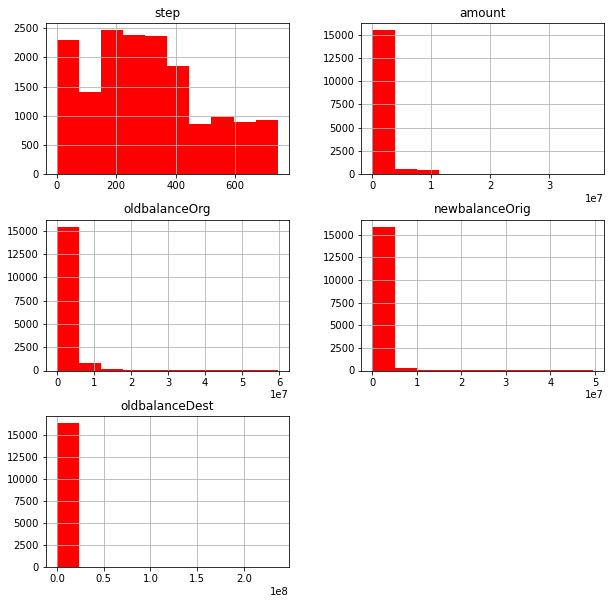

In [125]:
X[best].hist(figsize=(10,10),color='red')

In [126]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.95081
1    0.04919
Name: ex_, dtype: float64

In [127]:
X = X.loc[X['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>],
       [<AxesSubplot:title={'center':'oldbalanceOrg'}>,
        <AxesSubplot:title={'center':'newbalanceOrig'}>],
       [<AxesSubplot:title={'center':'oldbalanceDest'}>, <AxesSubplot:>]],
      dtype=object)

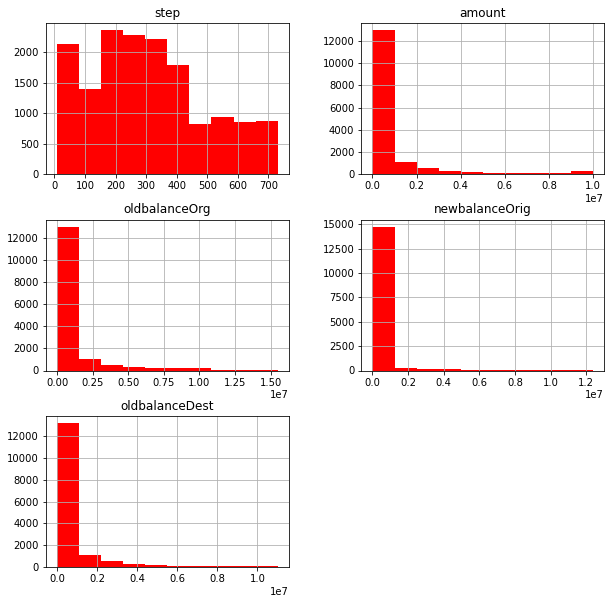

In [128]:
X[best].hist(figsize=(10,10),color='red')

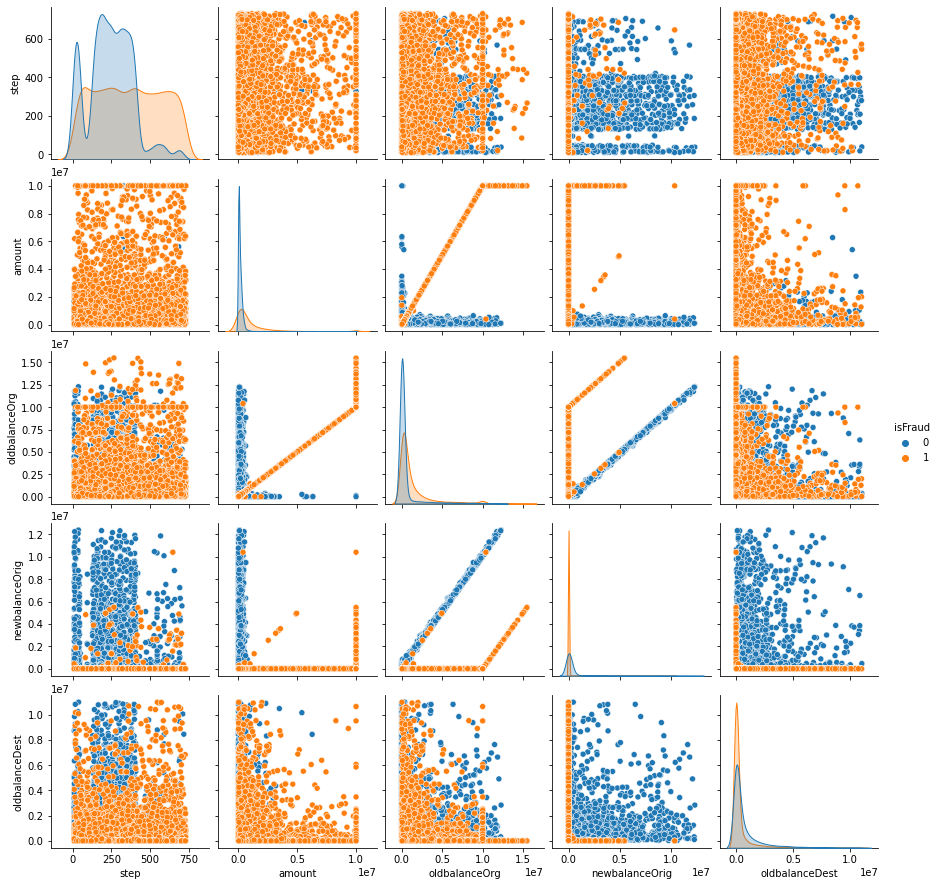

In [129]:
sns.pairplot(data=X[best+vart],hue=vart[0])

### Cambio de espacio $\mathcal{X}_{[0,1]}$

In [130]:
sc = MinMaxScaler()
sc.fit(X[best])

MinMaxScaler()

In [131]:
X01 = pd.DataFrame(sc.transform(X[best]), columns=best)
X01[um+vart] = X[um+vart]

## Partición

In [132]:
Xt,Xv,yt,yv = train_test_split(X01[um+best],X01[um+vart],test_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Aprendizaje

In [133]:
modelo = LinearDiscriminantAnalysis()
modelo.fit(Xt[best],yt[vart[0]])

LinearDiscriminantAnalysis()

## Validación del modelo

In [134]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [135]:
St['y^'] = modelo.predict(Xt[best])
Sv['y^'] = modelo.predict(Xv[best])

St['proba'] = modelo.predict_proba(Xt[best])[:,1]
Sv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [136]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.7745997865528281
0.7813043080581725


In [137]:
print(roc_auc_score(y_true=St[vart[0]],y_score=St['proba']))
print(roc_auc_score(y_true=Sv[vart[0]],y_score=Sv['proba']))

0.8551579704341954
0.8653262525315947


In [138]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[2073  323]
 [ 733 1556]]
[[4664  767]
 [1624 3878]]
